In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd 
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

In [3]:
train_path = "training_set/training_set"
test_path = "test_set/test_set"
image_size = (224,224)
Batch_size = 32

In [4]:
train_datagen=ImageDataGenerator(rescale=(1/255.0),
                                zoom_range=0.2,
                                rotation_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.1)

test_datagen=ImageDataGenerator(rescale=(1/255.0))

In [5]:
training=train_datagen.flow_from_directory(directory=train_path, 
                                            target_size=image_size, 
                                           classes=['cats', 'dogs'], 
                                           batch_size=Batch_size, 
                                           shuffle=True,
                                           class_mode="binary")

                        
testing=test_datagen.flow_from_directory(directory= test_path,
                                        target_size=image_size, 
                                        classes=['cats', 'dogs'], 
                                       batch_size=Batch_size, 
                                       shuffle=False,
                                       class_mode="binary")

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [6]:
training.class_indices

{'cats': 0, 'dogs': 1}

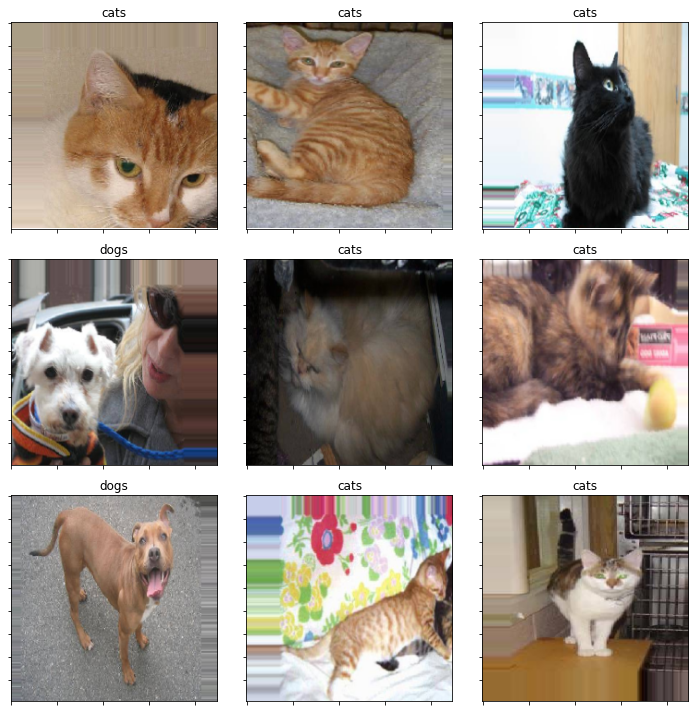

In [7]:
some_pets = training[0][0][:9]
cate = training[0][1][:9]

def fn(x):
    if x == 0:
        return "cats"
    elif x == 1:
        return "dogs"

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for tit,img, ax in zip(cate,some_pets, axes.flatten()):
    ax.imshow(img)
    ax.tick_params(
        labelbottom=False,
        labelleft=False
    )
    ax.set_title(fn(tit))
    
plt.tight_layout()
plt.show()

In [8]:
base_model = MobileNet(input_shape=(224,224,3),
                        include_top=False,
                        weights='imagenet',
                        pooling='avg')
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 70
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

prediction_layer = Dense(1,activation="sigmoid")

Number of layers in the base model:  87


In [9]:
model = Sequential([
  base_model,
  prediction_layer
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,858,049
Non-trainable params: 1,371,840
_________________________________________________________________


In [11]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy',
                    mode='max',patience=5,
                    restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [12]:
history = model.fit(training,
                    validation_data=testing,
                    epochs=30,
                    steps_per_epoch=32,
                    validation_steps=len(testing),
                    callbacks=[early_stopping,
                                learning_rate_reduction]
                    )

Epoch 1/30
32/32 [==============================] - 112s 3s/step - loss: 0.2076 - accuracy: 0.9157 - val_loss: 0.2520 - val_accuracy: 0.9348
Epoch 2/30
32/32 [==============================] - 59s 2s/step - loss: 0.1807 - accuracy: 0.9463 - val_loss: 0.1028 - val_accuracy: 0.9659
Epoch 3/30
32/32 [==============================] - 46s 1s/step - loss: 0.0947 - accuracy: 0.9707 - val_loss: 0.2441 - val_accuracy: 0.9283
Epoch 4/30
32/32 [==============================] - 55s 2s/step - loss: 0.0756 - accuracy: 0.9775 - val_loss: 0.2932 - val_accuracy: 0.9224
Epoch 5/30
32/32 [==============================] - 51s 2s/step - loss: 0.0607 - accuracy: 0.9785 - val_loss: 0.0443 - val_accuracy: 0.9837
Epoch 6/30
32/32 [==============================] - 37s 1s/step - loss: 0.0742 - accuracy: 0.9795 - val_loss: 0.0548 - val_accuracy: 0.9827
Epoch 7/30
32/32 [==============================] - 35s 1s/step - loss: 0.0719 - accuracy: 0.9707 - val_loss: 0.1727 - val_accuracy: 0.9451
Epoch 8/30
32/32 [=

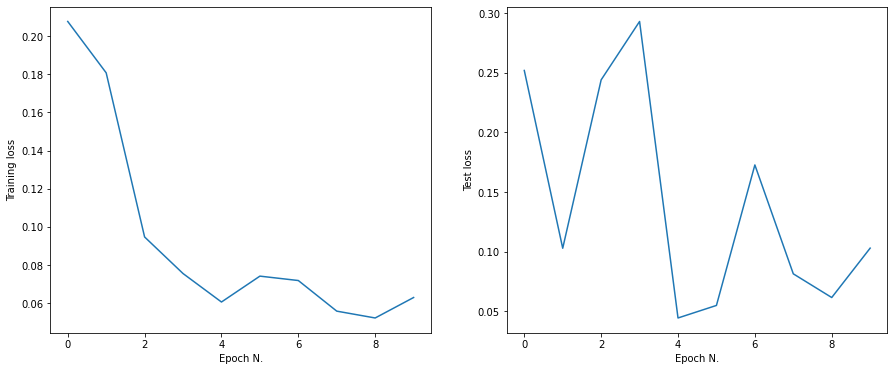

In [13]:
plt.figure(figsize=(15,6))
ax = plt.subplot(1, 2, 1)
ax.set_xlabel("Epoch N.")
ax.set_ylabel("Training loss")

plt.plot(history.history['loss'],axes = ax)

ax = plt.subplot(1, 2, 2)
ax.set_xlabel("Epoch N.")
ax.set_ylabel("Test loss")
plt.plot(history.history['val_loss'],axes = ax)

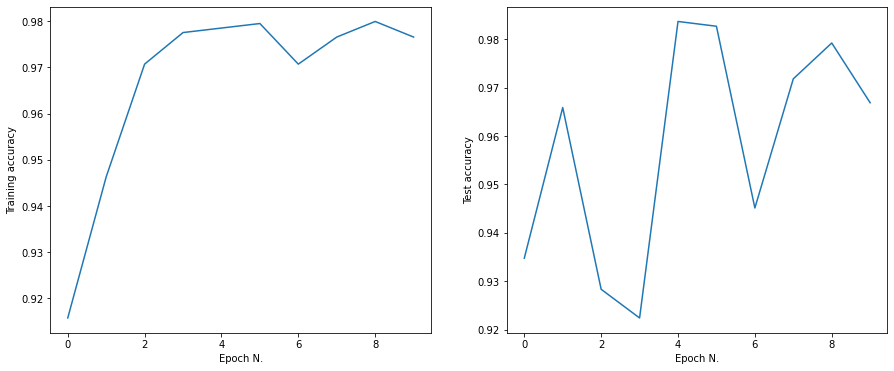

In [14]:
plt.figure(figsize=(15,6))
ax = plt.subplot(1, 2, 1)
ax.set_xlabel("Epoch N.")
ax.set_ylabel("Training accuracy")

plt.plot(history.history['accuracy'],axes = ax)
ax = plt.subplot(1, 2, 2)
ax.set_xlabel("Epoch N.")
ax.set_ylabel("Test accuracy")

plt.plot(history.history['val_accuracy'],axes = ax)

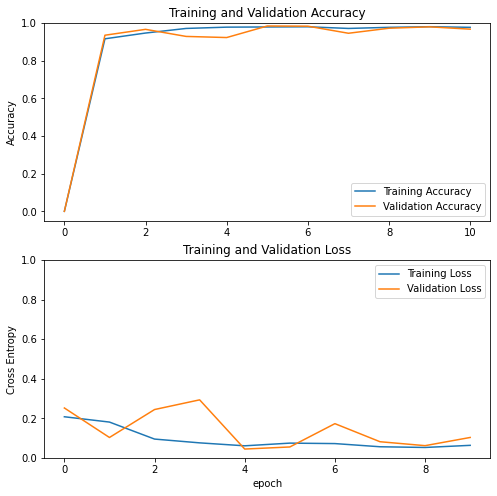

In [15]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
model.save('model.h5')